# Imports

In [1]:
%matplotlib inline
import pickle
import numpy as np
import matplotlib.pyplot as plt
import datacube
dc = datacube.Datacube(config='/g/data/u46/users/brl654/datacube/simoncube.conf')

# Functions

In [2]:
def numpy_to_xarray(array, geobox, name=None):
    """Utility to convert ndarray to DataArray, using a datacube.model.GeoBox"""
    import xarray
    coords=[xarray.Coordinate(x, geobox.coords[x].values, attrs=dict(units=geobox.coords[x].units)) 
            for x in geobox.dims]
    return xarray.DataArray(array, coords=coords, attrs=dict(crs=geobox.crs), name=name)

def rasterfile_to_xarray(file, geobox, name=None, nodata=None, src_nodata=None):
    """Blit like"""
    import rasterio
    with rasterio.open(file) as src:
        assert src.indexes == (1,) # assume single band
        band = rasterio.band(src, 1) # do not attempt to read entire extent into memory
        array = np.empty((geobox.height, geobox.width), dtype=band.dtype)
        rasterio.warp.reproject(source=band,
                                destination=array,
                                dst_crs=geobox.crs.crs_str,
                                dst_transform=geobox.affine,
                                dst_nodata=nodata,
                                src_nodata=src_nodata)
    return numpy_to_xarray(array, geobox, name)

# Find and inspect one layer

In [3]:
ds = dc.find_datasets(product='s1_gamma0_scene')[55] # grab metadata record concerning an example dataset/layer
ds.center_time # find what time it corresponds to

datetime.datetime(2016, 12, 6, 19, 36, 10, 283315)

This part of the code reads in the data

In [4]:
lon = 149.387, 147.83
lat = -21.155, -19.92
x = dc.load(product='s1_gamma0_scene', lat=lat, lon=lon, time=ds.center_time, output_crs='epsg:3577', resolution=(-25,25)) # load that one layer
x

<xarray.Dataset>
Dimensions:  (time: 1, x: 7118, y: 6291)
Coordinates:
  * time     (time) datetime64[ns] 2016-12-06T19:36:10.283315
  * y        (y) float64 -2.237e+06 -2.237e+06 -2.237e+06 -2.237e+06 ...
  * x        (x) float64 1.629e+06 1.629e+06 1.629e+06 1.629e+06 1.629e+06 ...
Data variables:
    vh       (time, y, x) float32 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 ...
    vv       (time, y, x) float32 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 ...
Attributes:
    crs:      epsg:3577

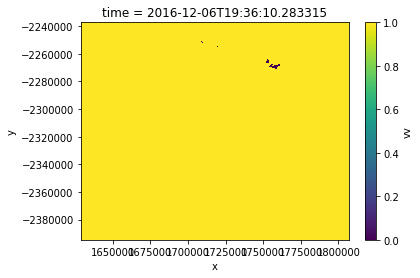

In [5]:
(x.isel(time=0).vv[::10,::10]==0).plot()

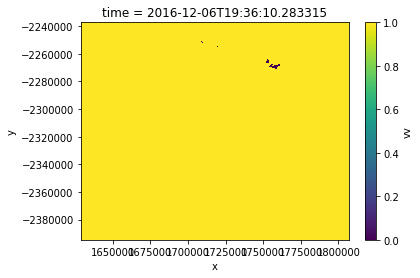

In [6]:
#x.vv[:,::2,::2].plot(vmax=0.001)
(x.isel(time=0).vv[::10,::10]==0).plot()

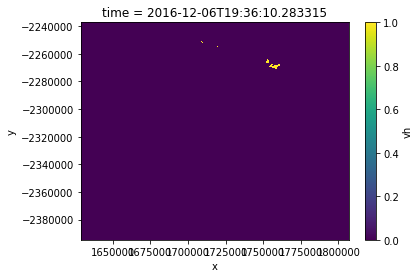

In [7]:
(x.vh != x.vh.nodata)[:,::10,::10].plot()

# Reset. Clear everything in memory and start again with All Layers

Note this command clears EVERYTHING, so need to reload modules

# Obtain All Layers 

In [8]:
%reset -f

In [9]:
#Imports - 
%matplotlib inline
import pickle
import numpy as np
import matplotlib.pyplot as plt
import datacube
dc = datacube.Datacube(config='/g/data/u46/users/brl654/datacube/simoncube.conf')

In [10]:
#Define Functions - 
def numpy_to_xarray(array, geobox, name=None):
    """Utility to convert ndarray to DataArray, using a datacube.model.GeoBox"""
    import xarray
    coords=[xarray.Coordinate(x, geobox.coords[x].values, attrs=dict(units=geobox.coords[x].units)) 
            for x in geobox.dims]
    return xarray.DataArray(array, coords=coords, attrs=dict(crs=geobox.crs), name=name)

def rasterfile_to_xarray(file, geobox, name=None, nodata=None, src_nodata=None):
    """Blit like"""
    import rasterio
    with rasterio.open(file) as src:
        assert src.indexes == (1,) # assume single band
        band = rasterio.band(src, 1) # do not attempt to read entire extent into memory
        array = np.empty((geobox.height, geobox.width), dtype=band.dtype)
        rasterio.warp.reproject(source=band,
                                destination=array,
                                dst_crs=geobox.crs.crs_str,
                                dst_transform=geobox.affine,
                                dst_nodata=nodata,
                                src_nodata=src_nodata)
    return numpy_to_xarray(array, geobox, name)

# Obtain all Layers

In [11]:
cache = '/g/data/u46/users/sj9724/xarray.pickle.debbie'
lon = 148.68, 148.21
lat = -20.30, -20.12 # call for partial Debbie area
try:
    with open(cache, 'rb') as file:
        z = pickle.load(file) # this only takes tens of seconds. (6GB)
except:
    # this may be 5 to 10 mintues (seeking through half a terabyte)
    z = dc.load(product='s1_gamma0_scene', lat=lat, lon=lon, output_crs='epsg:3577', resolution=(-25,25))
    with open(cache, 'wb') as file:
        pickle.dump(z, file, protocol=-1) # save result to disk

In [12]:
z.keys()

KeysView(<xarray.Dataset>
Dimensions:  (time: 46, x: 2042, y: 1047)
Coordinates:
  * time     (time) datetime64[ns] 2015-02-27T19:36:17.138714 ...
  * y        (y) float64 -2.264e+06 -2.264e+06 -2.264e+06 -2.264e+06 ...
  * x        (x) float64 1.68e+06 1.68e+06 1.68e+06 1.68e+06 1.68e+06 ...
Data variables:
    vh       (time, y, x) float32 0.0513276 0.039815 0.0677744 0.0422564 ...
    vv       (time, y, x) float32 0.116646 0.0728239 0.149574 0.140239 ...
Attributes:
    crs:      epsg:3577)

# Count observations
Patterns in the observation count often explain flaws in downstream products.

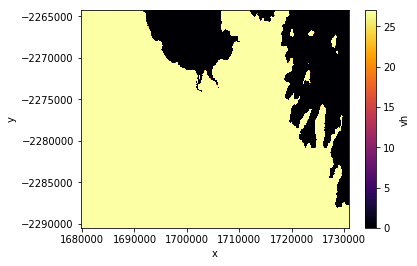

In [13]:
counts = (z.vh!=z.vh.nodata).sum(dim='time')
counts[::4,::4].plot(cmap='inferno')

In [14]:
z.time

<xarray.DataArray 'time' (time: 46)>
array(['2015-02-27T19:36:17.138714000', '2015-11-30T19:36:20.293880000',
       '2016-07-27T19:36:27.587660000', '2016-08-08T19:36:25.539364000',
       '2016-08-20T19:36:26.230637000', '2016-09-01T19:36:26.500684000',
       '2016-09-13T19:36:27.109793000', '2016-09-25T19:36:30.314403000',
       '2016-10-07T19:36:30.289778000', '2016-10-14T19:28:34.184254000',
       '2016-10-19T19:36:30.180867000', '2016-10-26T19:28:34.293807000',
       '2016-10-31T19:36:30.367010000', '2016-11-07T19:28:34.078163000',
       '2016-11-12T19:36:30.178718000', '2016-11-19T19:28:33.883653000',
       '2016-12-01T19:28:33.542089000', '2016-12-06T19:36:10.283315000',
       '2016-12-06T19:36:37.297220000', '2016-12-18T19:36:09.809539000',
       '2016-12-18T19:36:36.829356000', '2016-12-30T19:36:09.454881000',
       '2016-12-30T19:36:36.459163000', '2017-01-11T19:36:07.924789000',
       '2017-01-11T19:36:34.939440000', '2017-01-23T19:36:07.612445000',
       '2017-0

['2015-02-27T19:36:17.138714000' '2015-11-30T19:36:20.293880000']


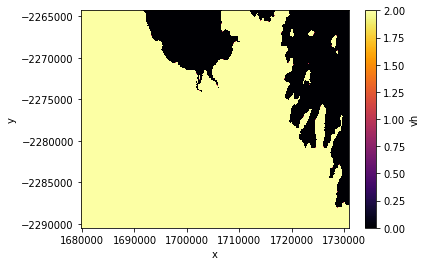

In [15]:
#time_slice = slice(None,'2016-11-12T19:36:30.178718000')
time_slice = slice('2015-01-01','2016-05-01')
z_subset = z.sel(time=time_slice)
print(z_subset.time.values)
(z_subset.vh!=z_subset.vh.nodata).sum(dim='time')[::4,::4].plot(cmap='inferno')

# Average signal
A naive mean will fail to account for different numbers of observations in different areas.

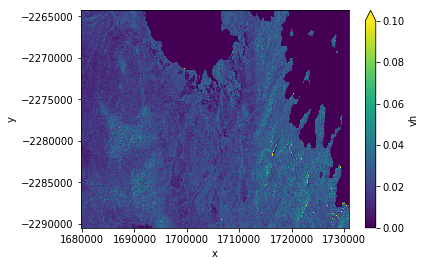

In [16]:
z.vh[:,::4,::4].mean(dim='time').plot(vmax=0.1)

This bit tells me what the 'no data' value is for this dataset

In [17]:
z.vh.nodata

0

/g/data/v10/public/modules/agdc-py3-env/20170904/envs/agdc/lib/python3.6/site-packages/xarray/core/variable.py:1164: RuntimeWarning: invalid value encountered in true_divide
  if not reflexive


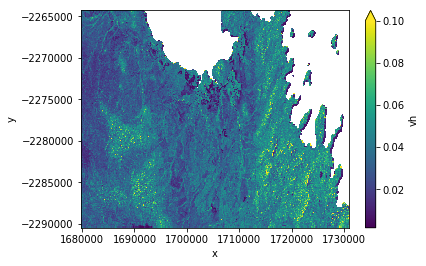

In [18]:
average = (z.vh[:,::4,::4].sum(dim='time') / counts)
average.plot(vmax=0.1)

# Problem 1 - Identified in Larry notebook - 
areas where the data is very close to zero but not quite zero

problem = z.sel(time='2017-04-10T19:44:05.949922000').vh[::4,::4].copy()
problem.data[problem.data==0] = np.nan
problem.plot(vmax=0.00001)
(problem < 0.0001).plot() # problem identified - areas where the data is very close to zero but not quite


# Problem 1 - Solution -
We now run the same script that produced the 'problem' image but define where there is data >0.001.  Voilà! Clean image

/g/data/v10/public/modules/agdc-py3-env/20170904/envs/agdc/lib/python3.6/site-packages/xarray/core/variable.py:1164: RuntimeWarning: divide by zero encountered in true_divide
  if not reflexive
/g/data/v10/public/modules/agdc-py3-env/20170904/envs/agdc/lib/python3.6/site-packages/xarray/core/variable.py:1164: RuntimeWarning: invalid value encountered in true_divide
  if not reflexive


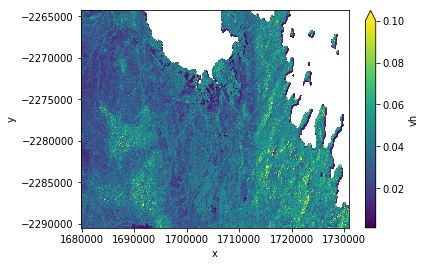

In [19]:
new_counts = (z.vh>0.001).sum(dim='time')
new_average = (z.vh.sum(dim='time') / new_counts)
# technically this equation is wrong. We should zero the values that are less than 0.001.. But this is approximately right
new_average.plot(vmax=0.1)

In [20]:
# write out the pickled file
with open('/g/data/u46/users/sj9724/average_radar', 'wb') as file:
    radar = pickle.dump(new_average, file)

# Clear everything in memory and start over with the created files
Note this command clears EVERYTHING, so need to reload modules

In [21]:
%reset -f

In [22]:
#Imports - 
%matplotlib inline
import pickle
import numpy as np
import matplotlib.pyplot as plt
import datacube
import pandas as pd
dc = datacube.Datacube(config='/g/data/u46/users/brl654/datacube/simoncube.conf')
import seaborn as sns

In [23]:
#Define Functions - 
def numpy_to_xarray(array, geobox, name=None):
    """Utility to convert ndarray to DataArray, using a datacube.model.GeoBox"""
    import xarray
    coords=[xarray.Coordinate(x, geobox.coords[x].values, attrs=dict(units=geobox.coords[x].units)) 
            for x in geobox.dims]
    return xarray.DataArray(array, coords=coords, attrs=dict(crs=geobox.crs), name=name)

def rasterfile_to_xarray(file, geobox, name=None, nodata=None, src_nodata=None):
    """Blit like"""
    import rasterio
    with rasterio.open(file) as src:
        assert src.indexes == (1,) # assume single band
        band = rasterio.band(src, 1) # do not attempt to read entire extent into memory
        array = np.empty((geobox.height, geobox.width), dtype=band.dtype)
        rasterio.warp.reproject(source=band,
                                destination=array,
                                dst_crs=geobox.crs.crs_str,
                                dst_transform=geobox.affine,
                                dst_nodata=nodata,
                                src_nodata=src_nodata)
    return numpy_to_xarray(array, geobox, name)

In [24]:
#Bring in the averaged radar file to start analysis
import pickle
with open('/g/data/u46/users/sj9724/average_radar', 'rb') as file:
    radar = pickle.load(file) 


In [25]:
ds = dc.find_datasets(product='s1_gamma0_scene')[3] # grab metadata record concerning an example dataset/layer
ds.center_time # find what time it corresponds to
lon = 148.68, 148.21
lat = -20.30, -20.12
x = dc.load(product='s1_gamma0_scene', lat=lat, lon=lon, time=ds.center_time, output_crs='epsg:3577', resolution=(-25,25)) # load that one layer
mz = rasterfile_to_xarray('/g/data/u46/users/sj9724/Landsat_terrain_classification/mzcat_debbie2.tif', x.geobox, nodata=np.nan, src_nodata=-999.5)
cats = rasterfile_to_xarray('/g/data/u46/users/sj9724/Landsat_terrain_classification/classified_TCDebbie.nc', x.geobox)

/g/data/v10/public/modules/agdc-py3-env/20170904/envs/agdc/lib/python3.6/site-packages/ipykernel_launcher.py:6: FutureWarning: Coordinate has been deprecated. Use IndexVariable instead.
  


In [26]:
radar

<xarray.DataArray 'vh' (y: 1047, x: 2042)>
array([[ 0.027586,  0.037789,  0.03372 , ...,       nan,       nan,       nan],
       [ 0.033448,  0.038418,  0.032688, ...,       nan,       nan,       nan],
       [ 0.038186,  0.032541,  0.033092, ...,       nan,       nan,       nan],
       ..., 
       [ 0.033756,  0.027862,  0.029023, ...,  0.054011,  0.061083,  0.055036],
       [ 0.034426,  0.018685,  0.02464 , ...,  0.062814,  0.053808,  0.042923],
       [ 0.029306,  0.030003,  0.027632, ...,  0.051596,  0.040562,  0.035227]])
Coordinates:
  * y        (y) float64 -2.264e+06 -2.264e+06 -2.264e+06 -2.264e+06 ...
  * x        (x) float64 1.68e+06 1.68e+06 1.68e+06 1.68e+06 1.68e+06 ...

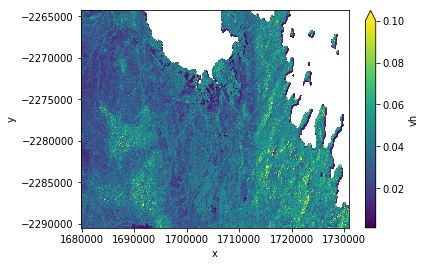

In [27]:
radar.plot(vmax=0.1)

In [28]:
mz

<xarray.DataArray (y: 1047, x: 2042)>
array([[  949.,   949.,   949., ...,  1000.,  1000.,  1000.],
       [  949.,   949.,   949., ...,  1000.,  1000.,  1000.],
       [  949.,   949.,   949., ...,  1000.,  1000.,  1000.],
       ..., 
       [  949.,   949.,   949., ...,   774.,   774.,   774.],
       [  949.,   949.,   949., ...,   774.,   774.,   774.],
       [  949.,   949.,   949., ...,   774.,   774.,   774.]])
Coordinates:
  * y        (y) float64 -2.264e+06 -2.264e+06 -2.264e+06 -2.264e+06 ...
  * x        (x) float64 1.68e+06 1.68e+06 1.68e+06 1.68e+06 1.68e+06 ...
Attributes:
    crs:      epsg:3577

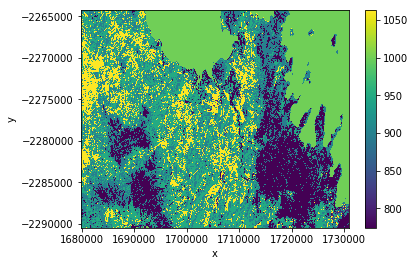

In [29]:
mz.plot()

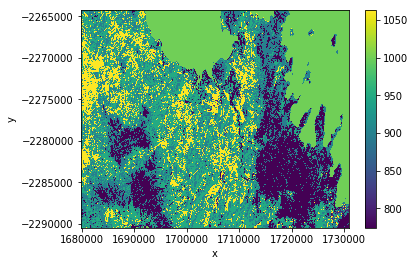

In [30]:
cats.plot()

# Clear everything and start Radar vs Mz Cat Data analysis

In [31]:
%reset -f

In [32]:
#Imports - 
%matplotlib inline
import pickle
import numpy as np
import matplotlib.pyplot as plt
import datacube
import pandas as pd
dc = datacube.Datacube(config='/g/data/u46/users/brl654/datacube/simoncube.conf')
import seaborn as sns
import pandas as pd

In [33]:
#Define Functions - 
def numpy_to_xarray(array, geobox, name=None):
    """Utility to convert ndarray to DataArray, using a datacube.model.GeoBox"""
    import xarray
    coords=[xarray.Coordinate(x, geobox.coords[x].values, attrs=dict(units=geobox.coords[x].units)) 
            for x in geobox.dims]
    return xarray.DataArray(array, coords=coords, attrs=dict(crs=geobox.crs), name=name)

def rasterfile_to_xarray(file, geobox, name=None, nodata=None, src_nodata=None):
    """Blit like"""
    import rasterio
    with rasterio.open(file) as src:
        assert src.indexes == (1,) # assume single band
        band = rasterio.band(src, 1) # do not attempt to read entire extent into memory
        array = np.empty((geobox.height, geobox.width), dtype=band.dtype)
        rasterio.warp.reproject(source=band,
                                destination=array,
                                dst_crs=geobox.crs.crs_str,
                                dst_transform=geobox.affine,
                                dst_nodata=nodata,
                                src_nodata=src_nodata)
    return numpy_to_xarray(array, geobox, name)

In [34]:
#Bring in the averaged radar file to start analysis
import pickle
with open('/g/data/u46/users/sj9724/average_radar', 'rb') as file:
    radar = pickle.load(file) 


In [35]:
ds = dc.find_datasets(product='s1_gamma0_scene')[3] # grab metadata record concerning an example dataset/layer
ds.center_time # find what time it corresponds to
lon = 148.68, 148.21
lat = -20.30, -20.12
x = dc.load(product='s1_gamma0_scene', lat=lat, lon=lon, time=ds.center_time, output_crs='epsg:3577', resolution=(-25,25)) # load that one layer
mz = rasterfile_to_xarray('/g/data/u46/users/sj9724/Landsat_terrain_classification/mzcat_debbie2.tif', x.geobox, nodata=np.nan, src_nodata=-999.5)
cats = rasterfile_to_xarray('/g/data/u46/users/sj9724/Landsat_terrain_classification/classified_TCDebbie.nc', x.geobox)

/g/data/v10/public/modules/agdc-py3-env/20170904/envs/agdc/lib/python3.6/site-packages/ipykernel_launcher.py:6: FutureWarning: Coordinate has been deprecated. Use IndexVariable instead.
  


# Now we want to plot a scatter of radar vs Mz data

In [36]:
# Need to get the radar and cats data into a single list by 'flattening' the data using- 
flatcats = cats.stack(i = ('x','y'))
flatmz = mz.stack(i = ('x','y'))
flatradar = radar.stack(i = ('x','y'))
# Check that they are still looking good
print(flatcats)
print(flatmz) 
print(flatradar)

<xarray.DataArray (i: 2137974)>
array([ 949.,  949.,  949., ...,  774.,  774.,  774.])
Coordinates:
  * i        (i) MultiIndex
  - x        (i) float64 1.68e+06 1.68e+06 1.68e+06 1.68e+06 1.68e+06 ...
  - y        (i) float64 -2.264e+06 -2.264e+06 -2.264e+06 -2.264e+06 ...
Attributes:
    crs:      epsg:3577
<xarray.DataArray (i: 2137974)>
array([ 949.,  949.,  949., ...,  774.,  774.,  774.])
Coordinates:
  * i        (i) MultiIndex
  - x        (i) float64 1.68e+06 1.68e+06 1.68e+06 1.68e+06 1.68e+06 ...
  - y        (i) float64 -2.264e+06 -2.264e+06 -2.264e+06 -2.264e+06 ...
Attributes:
    crs:      epsg:3577
<xarray.DataArray 'vh' (i: 2137974)>
array([ 0.027586,  0.033448,  0.038186, ...,  0.055036,  0.042923,  0.035227])
Coordinates:
  * i        (i) MultiIndex
  - x        (i) float64 1.68e+06 1.68e+06 1.68e+06 1.68e+06 1.68e+06 ...
  - y        (i) float64 -2.264e+06 -2.264e+06 -2.264e+06 -2.264e+06 ...


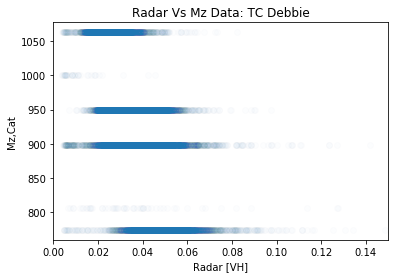

In [37]:
#If they are looking good, we can now do our scatter plot
fig, ax = plt.subplots()
ax.scatter(flatradar[::100], flatmz[::100] , alpha = 0.01)


# We want to limit the xaxis scale to 0-0.10 - xlimit?
ax.set_xlim([0, 0.15]) 
#ax.set_ylim([0,1.01])

#Add axes labels (radar and Mzcat)(label categ.)
ax.set_xlabel('Radar [VH]')
ax.set_ylabel('Mz,Cat')
ax.set_title('Radar Vs Mz Data: TC Debbie')
plt.show()

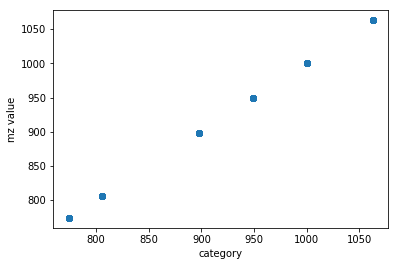

In [38]:
plt.scatter(flatcats.data[::10], flatmz.data[::10])
plt.xlabel('category')
plt.ylabel('mz value')
plt.show()

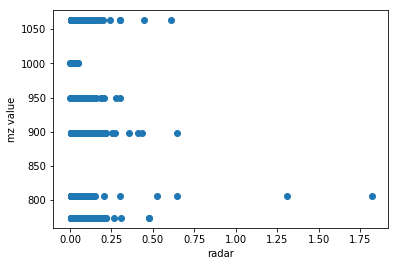

In [39]:
plt.scatter(flatradar.data[::10], flatmz.data[::10])
plt.xlabel('radar')
plt.ylabel('mz value')
plt.show()

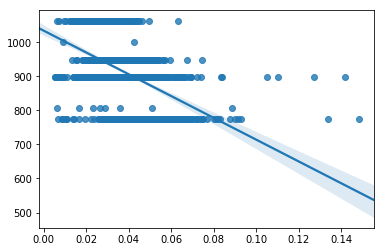

In [40]:
#ax = sns.regplot(x="flatradar", y="flatmz")
sns.regplot(x=flatradar.data[::1000], y=flatmz.data[::1000])
ax.set_xlabel('Radar [VH]')
ax.set_ylabel('Mz,Cat')
ax.set_title('Radar Vs Mz Data: TC Debbie')
plt.show()

# Produce histograms of flat data to interrogate results of scatter plot

In [41]:
#Remove NaN's and inf from data before plotting histogram of flatmz
#1. Id NaN's

def nanfree(mz):
    return x[~np.isnan(mz)]
def clean(mz):
    return x[np.isfinite(mz)]
#mznan = flatmz.dropna(dim = '?')
#nanlist = np.argwhere(pd.isnull(mznan))
#nanlist
# Identify NaN's in flat mz
mznan = flatmz.dropna(dim = 'i')
nanlist = np.argwhere(pd.isnull(mznan))
nanlist # show where nans still are (if any)

array([], shape=(0, 1), dtype=int64)

In [42]:
#Remove infinites (inf) from data
mznan.loc[~np.isfinite(mznan)] = np.nan
mznan = mznan.dropna(dim = 'i')
mznan

<xarray.DataArray (i: 2137689)>
array([ 949.,  949.,  949., ...,  774.,  774.,  774.])
Coordinates:
  * i        (i) MultiIndex
  - x        (i) float64 1.68e+06 1.68e+06 1.68e+06 1.68e+06 1.68e+06 ...
  - y        (i) float64 -2.264e+06 -2.264e+06 -2.264e+06 -2.264e+06 ...
Attributes:
    crs:      epsg:3577

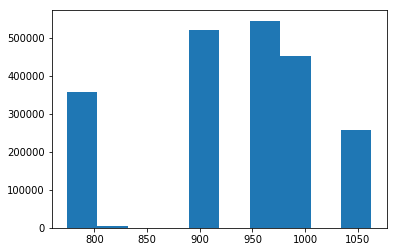

In [43]:
plt.hist(mznan, 10) # plot flattened Mz,cat - flatmz
plt.show()

In [44]:
# Identify NaN's in flat radar
radarnan = flatradar.dropna(dim = 'i')
nanlist = np.argwhere(pd.isnull(radarnan))
nanlist

array([], shape=(0, 1), dtype=int64)

In [45]:
#Remove infinites (inf) from data
radarnan.loc[~np.isfinite(radarnan)] = np.nan
radarnan = radarnan.dropna(dim = 'i')

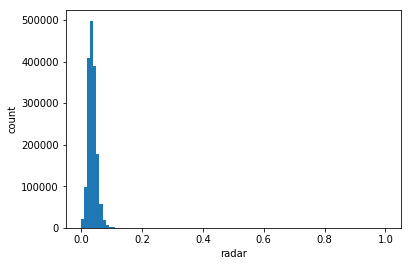

In [46]:
plt.hist(radarnan, bins=np.linspace(0,1,100)) # A histogram of our flat radar data after NaNs are removed.
plt.xlabel('radar')
plt.ylabel('count')
plt.show()

%reset -f

#Imports - 
%matplotlib inline
import pickle
import numpy as np
import matplotlib.pyplot as plt
import datacube
import pandas as pd
dc = datacube.Datacube(config='/g/data/u46/users/brl654/datacube/simoncube.conf')
import seaborn as sns
import pandas as pd

#Define Functions - 
def numpy_to_xarray(array, geobox, name=None):
    """Utility to convert ndarray to DataArray, using a datacube.model.GeoBox"""
    import xarray
    coords=[xarray.Coordinate(x, geobox.coords[x].values, attrs=dict(units=geobox.coords[x].units)) 
            for x in geobox.dims]
    return xarray.DataArray(array, coords=coords, attrs=dict(crs=geobox.crs), name=name)

def rasterfile_to_xarray(file, geobox, name=None, nodata=None, src_nodata=None):
    """Blit like"""
    import rasterio
    with rasterio.open(file) as src:
        assert src.indexes == (1,) # assume single band
        band = rasterio.band(src, 1) # do not attempt to read entire extent into memory
        array = np.empty((geobox.height, geobox.width), dtype=band.dtype)
        rasterio.warp.reproject(source=band,
                                destination=array,
                                dst_crs=geobox.crs.crs_str,
                                dst_transform=geobox.affine,
                                dst_nodata=nodata,
                                src_nodata=src_nodata)
    return numpy_to_xarray(array, geobox, name)

#Bring in the averaged radar file to start analysis
import pickle
with open('/g/data1/w85/sj9724/average_radar', 'rb') as file:
    radar = pickle.load(file) 

ds = dc.find_datasets(product='s1_gamma0_scene')[3] # grab metadata record concerning an example dataset/layer
ds.center_time # find what time it corresponds to
lon = 148.68, 148.21
lat = -20.30, -20.12
x = dc.load(product='s1_gamma0_scene', lat=lat, lon=lon, time=ds.center_time, output_crs='epsg:3577', resolution=(-25,25)) # load that one layer
mz = rasterfile_to_xarray('/g/data/w85/TCDebbie/Landsat_terrain_classification/mzcat_debbie2.tif', x.geobox, nodata=np.nan, src_nodata=-999.5)
cats = rasterfile_to_xarray('/g/data/w85/TCDebbie/Landsat_terrain_classification/classified_TCDebbie.nc', x.geobox)

# Need to get the radar and cats data into a single list by 'flattening' the data using- 
flatcats = cats.stack(i = ('x','y'))
flatmz = mz.stack(i = ('x','y'))
flatradar = radar.stack(i = ('x','y'))
# Check that they are still looking good
print(flatcats)
print(flatmz) 
print(flatradar)

#Remove NaN's and inf from data before plotting histogram of flatmz
#1. Id NaN's

def nanfree(mz):
    return x[~np.isnan(mz)]
def clean(mz):
    return x[np.isfinite(mz)]
#mznan = flatmz.dropna(dim = '?')
#nanlist = np.argwhere(pd.isnull(mznan))
#nanlist
# Identify NaN's in flat mz
mznan = flatmz.dropna(dim = 'i')
nanlist = np.argwhere(pd.isnull(mznan))
nanlist # show where nans still are (if any)

In [47]:
flatcats.data.max()

nan

[ 774.]
[ 806.]
[ 898.]
[ 949.]
[ 1000.]
[ 1063.]


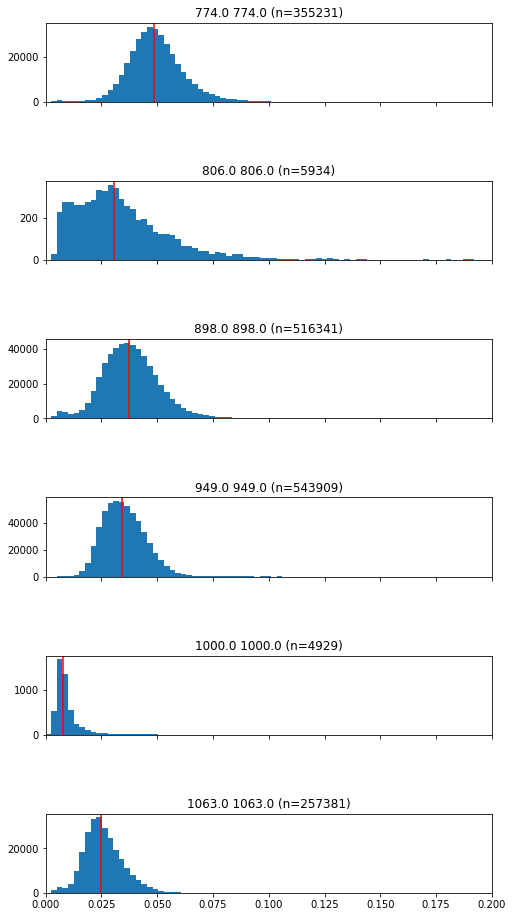

In [77]:
def nanfree(x):
    return x[~np.isnan(x)]
def clean(x):
    return x[np.isfinite(x)]


#plt.hist(subset, bins=np.linspace(0,0.25,100))
#plt.show()

values = np.unique(clean(flatcats.data)) # != range(11) ?

fig, axes = plt.subplots(nrows=len(values), ncols=1, figsize=(8,16), sharex=True)
axes = axes.ravel()



for i, ax in zip(values, axes):
    subset = clean(flatradar.data[flatcats.data == i])
    medi = np.median(subset)
    mz_i = np.unique(clean(flatmz.data[flatcats.data == i])) # find corresponding mz value
    print(mz_i)
    assert len(mz_i) == 1
    mz_i = mz_i[0]
    
    ax.hist(subset, bins=np.linspace(0,0.25,100))
    ax.axvline(medi, color='r')
    ax.set_title(str(i) + ' ' + str(mz_i) + ' (n=' + str(len(subset)) + ')')


fig.subplots_adjust(hspace=1)
ax.set_xlim([0,0.2])
plt.show()

In [49]:
np.unique(clean(flatcats.data))

array([  774.,   806.,   898.,   949.,  1000.,  1063.])

In [50]:
subset

array([ 0.02547835,  0.02095355,  0.01919008, ...,  0.02050175,
        0.03084656,  0.03532495])

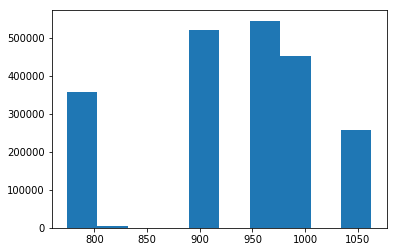

In [51]:
plt.hist(clean(flatcats.data), 10) # plot flattened categories - flatcat
plt.show()

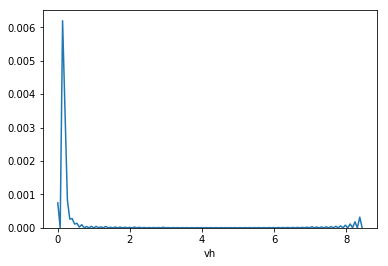

In [52]:
sns.distplot(radarnan, hist=False)

# Produce violin plots of radar against set categories

# Craig's code for categories
catmz = pd.DataFrame(np.zeros(len(flatmz.data), dtype='str'))
catmz[mznan.data == 1000] = "water"
catmz[mznan.data == 1063] = "bare ground"
catmz[mznan.data == 949] = "crops/grassland"
catmz[mznan.data == 898] = "open forest"
catmz[mznan.data == 806] = "urban"
catmz[mznan.data == 774] = "forest"
catmz

In [53]:
flatcats

<xarray.DataArray (i: 2137974)>
array([ 949.,  949.,  949., ...,  774.,  774.,  774.])
Coordinates:
  * i        (i) MultiIndex
  - x        (i) float64 1.68e+06 1.68e+06 1.68e+06 1.68e+06 1.68e+06 ...
  - y        (i) float64 -2.264e+06 -2.264e+06 -2.264e+06 -2.264e+06 ...
Attributes:
    crs:      epsg:3577

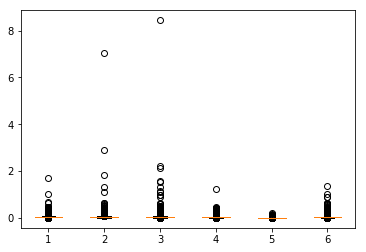

In [54]:
def g():
    for i, ax in zip(values, axes):
        subset = clean(flatradar.data[flatcats.data == i])
        yield subset
vector = list(g())
plt.boxplot(vector)
plt.show()

In [55]:
vector

[array([ 0.04452957,  0.04378988,  0.03544937, ...,  0.05503589,
         0.04292284,  0.03522677]),
 array([ 0.02816485,  0.01871524,  0.01281081, ...,  0.04964868,
         0.0527443 ,  0.03963047]),
 array([ 0.03412509,  0.03935186,  0.0321531 , ...,  0.03702294,
         0.03429846,  0.05521898]),
 array([ 0.02758587,  0.03344844,  0.03818595, ...,  0.04319096,
         0.03560075,  0.07432524]),
 array([ 0.01883681,  0.02053799,  0.02178335, ...,  0.05570681,
         0.00387117,  0.10701232]),
 array([ 0.02547835,  0.02095355,  0.01919008, ...,  0.02050175,
         0.03084656,  0.03532495])]

In [56]:
radar

<xarray.DataArray 'vh' (y: 1047, x: 2042)>
array([[ 0.027586,  0.037789,  0.03372 , ...,       nan,       nan,       nan],
       [ 0.033448,  0.038418,  0.032688, ...,       nan,       nan,       nan],
       [ 0.038186,  0.032541,  0.033092, ...,       nan,       nan,       nan],
       ..., 
       [ 0.033756,  0.027862,  0.029023, ...,  0.054011,  0.061083,  0.055036],
       [ 0.034426,  0.018685,  0.02464 , ...,  0.062814,  0.053808,  0.042923],
       [ 0.029306,  0.030003,  0.027632, ...,  0.051596,  0.040562,  0.035227]])
Coordinates:
  * y        (y) float64 -2.264e+06 -2.264e+06 -2.264e+06 -2.264e+06 ...
  * x        (x) float64 1.68e+06 1.68e+06 1.68e+06 1.68e+06 1.68e+06 ...

In [57]:
mz

<xarray.DataArray (y: 1047, x: 2042)>
array([[  949.,   949.,   949., ...,  1000.,  1000.,  1000.],
       [  949.,   949.,   949., ...,  1000.,  1000.,  1000.],
       [  949.,   949.,   949., ...,  1000.,  1000.,  1000.],
       ..., 
       [  949.,   949.,   949., ...,   774.,   774.,   774.],
       [  949.,   949.,   949., ...,   774.,   774.,   774.],
       [  949.,   949.,   949., ...,   774.,   774.,   774.]])
Coordinates:
  * y        (y) float64 -2.264e+06 -2.264e+06 -2.264e+06 -2.264e+06 ...
  * x        (x) float64 1.68e+06 1.68e+06 1.68e+06 1.68e+06 1.68e+06 ...
Attributes:
    crs:      epsg:3577

In [58]:
good_subset = np.isfinite(radar) & np.isfinite(mz)
good_radar = radar.data[good_subset]
good_mz = mz.data[good_subset]
#good_both = np.vstack([good_radar, good_mz])
df = pd.DataFrame(data=dict(radar_column=good_radar, mz_column=good_mz))
mapping = {1063:'bare', 1000:'water', 949:'grassy', 898:'woodland', 806:'urban', 774:'forest'}
df['mz_label'] = df.mz_column.map(mapping)
df.head() # only show a few rows

,mz_column,radar_column,mz_label
0,949.0,0.027586,grassy
1,949.0,0.037789,grassy
2,949.0,0.033720,grassy
3,949.0,0.032542,grassy
4,949.0,0.032714,grassy


(0, 0.09)

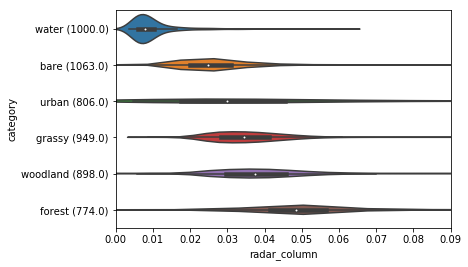

In [59]:
# Try to specify ordering of violin plot
df2 = df.copy()
df2['order'] = df2.mz_label.map(dict(water=1,bare=2,urban=3,grassy=4,woodland=5,forest=6))
df2.sort_values('order', inplace=True)
df2['category'] = df2.mz_label + ' (' + df2.mz_column.map(str) + ')'
ax = sns.violinplot(data=df2.iloc[::10], x='radar_column', y='category', scale="area")
ax.set_xlim([0,0.09])
#Clair's suggested scripting for ordering -
#order = ['water', 'bare', 'urban', 'grassy', 'woodland', 'forest']
#ax = sns.countplot(x="CONDITION", hue="HABITABLE", data=df, order=order)

In [60]:
df2.head()

,mz_column,radar_column,mz_label,order,category
199269,1000.0,0.010728,water,1,water (1000.0)
1085862,1000.0,0.009459,water,1,water (1000.0)
1085863,1000.0,0.008684,water,1,water (1000.0)
47210,1000.0,0.015093,water,1,water (1000.0)
1509222,1000.0,0.045859,water,1,water (1000.0)


(0, 0.1)

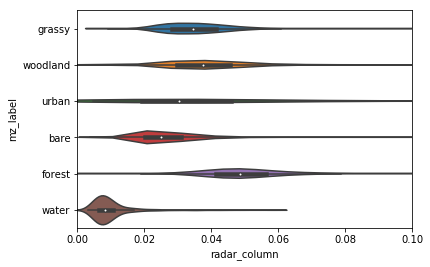

In [61]:
smaller = df.iloc[::10]
#len(smaller)
ax = sns.violinplot(data=smaller, x='radar_column', y='mz_label', scale="area")#, cut=0)#, bw=20)
ax.set_xlim([0,0.1])

# Pull out time slice before/after TC Debbie - analyse via violin plots

In [62]:
%reset -f

In [63]:
#Imports - 
%matplotlib inline
import pickle
import numpy as np
import matplotlib.pyplot as plt
import datacube
import pandas as pd
dc = datacube.Datacube(config='/g/data/u46/users/brl654/datacube/simoncube.conf')
import seaborn as sns
import pandas as pd

In [64]:
#Define Functions - 
def numpy_to_xarray(array, geobox, name=None):
    """Utility to convert ndarray to DataArray, using a datacube.model.GeoBox"""
    import xarray
    coords=[xarray.Coordinate(x, geobox.coords[x].values, attrs=dict(units=geobox.coords[x].units)) 
            for x in geobox.dims]
    return xarray.DataArray(array, coords=coords, attrs=dict(crs=geobox.crs), name=name)

def rasterfile_to_xarray(file, geobox, name=None, nodata=None, src_nodata=None):
    """Blit like"""
    import rasterio
    with rasterio.open(file) as src:
        assert src.indexes == (1,) # assume single band
        band = rasterio.band(src, 1) # do not attempt to read entire extent into memory
        array = np.empty((geobox.height, geobox.width), dtype=band.dtype)
        rasterio.warp.reproject(source=band,
                                destination=array,
                                dst_crs=geobox.crs.crs_str,
                                dst_transform=geobox.affine,
                                dst_nodata=nodata,
                                src_nodata=src_nodata)
    return numpy_to_xarray(array, geobox, name)

In [65]:
#Bring in the averaged radar file to start analysis
import pickle
with open('/g/data/u46/users/sj9724/average_radar', 'rb') as file:
    radar = pickle.load(file) 


In [66]:
ds = dc.find_datasets(product='s1_gamma0_scene')[3] # grab metadata record concerning an example dataset/layer
ds.center_time # find what time it corresponds to
lon = 148.68, 148.21
lat = -20.30, -20.12
x = dc.load(product='s1_gamma0_scene', lat=lat, lon=lon, time=ds.center_time, output_crs='epsg:3577', resolution=(-25,25)) # load that one layer
mz = rasterfile_to_xarray('/g/data/u46/users/sj9724/Landsat_terrain_classification/mzcat_debbie2.tif', x.geobox, nodata=np.nan, src_nodata=-999.5)
cats = rasterfile_to_xarray('/g/data/u46/users/sj9724/Landsat_terrain_classification/classified_TCDebbie.nc', x.geobox)

/g/data/v10/public/modules/agdc-py3-env/20170904/envs/agdc/lib/python3.6/site-packages/ipykernel_launcher.py:6: FutureWarning: Coordinate has been deprecated. Use IndexVariable instead.
  


# Count observations
Patterns in the observation count often explain flaws in downstream products.

In [67]:
cache = '/g/data/u46/users/sj9724/xarray.pickle.debbie'
lon = 148.68, 148.21
lat = -20.30, -20.12 # call for partial Debbie area
try:
    with open(cache, 'rb') as file:
        z = pickle.load(file) # this only takes tens of seconds. (6GB)
except:
    # this may be 5 to 10 mintues (seeking through half a terabyte)
    z = dc.load(product='s1_gamma0_scene', lat=lat, lon=lon, output_crs='epsg:3577', resolution=(-25,25))
    with open(cache, 'wb') as file:
        pickle.dump(z, file, protocol=-1) # save result to disk

In [68]:
z.keys()

KeysView(<xarray.Dataset>
Dimensions:  (time: 46, x: 2042, y: 1047)
Coordinates:
  * time     (time) datetime64[ns] 2015-02-27T19:36:17.138714 ...
  * y        (y) float64 -2.264e+06 -2.264e+06 -2.264e+06 -2.264e+06 ...
  * x        (x) float64 1.68e+06 1.68e+06 1.68e+06 1.68e+06 1.68e+06 ...
Data variables:
    vh       (time, y, x) float32 0.0513276 0.039815 0.0677744 0.0422564 ...
    vv       (time, y, x) float32 0.116646 0.0728239 0.149574 0.140239 ...
Attributes:
    crs:      epsg:3577)

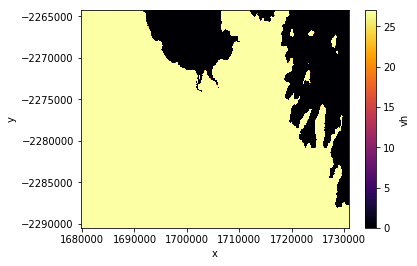

In [69]:
counts = (z.vh!=z.vh.nodata).sum(dim='time')
counts[::4,::4].plot(cmap='inferno')

In [70]:
z.time

<xarray.DataArray 'time' (time: 46)>
array(['2015-02-27T19:36:17.138714000', '2015-11-30T19:36:20.293880000',
       '2016-07-27T19:36:27.587660000', '2016-08-08T19:36:25.539364000',
       '2016-08-20T19:36:26.230637000', '2016-09-01T19:36:26.500684000',
       '2016-09-13T19:36:27.109793000', '2016-09-25T19:36:30.314403000',
       '2016-10-07T19:36:30.289778000', '2016-10-14T19:28:34.184254000',
       '2016-10-19T19:36:30.180867000', '2016-10-26T19:28:34.293807000',
       '2016-10-31T19:36:30.367010000', '2016-11-07T19:28:34.078163000',
       '2016-11-12T19:36:30.178718000', '2016-11-19T19:28:33.883653000',
       '2016-12-01T19:28:33.542089000', '2016-12-06T19:36:10.283315000',
       '2016-12-06T19:36:37.297220000', '2016-12-18T19:36:09.809539000',
       '2016-12-18T19:36:36.829356000', '2016-12-30T19:36:09.454881000',
       '2016-12-30T19:36:36.459163000', '2017-01-11T19:36:07.924789000',
       '2017-01-11T19:36:34.939440000', '2017-01-23T19:36:07.612445000',
       '2017-0

['2017-02-28T19:36:06.905976000' '2017-02-28T19:36:33.915487000'
 '2017-03-12T19:36:07.200560000' '2017-03-12T19:36:34.212385000'
 '2017-03-24T19:36:07.375644000' '2017-03-24T19:36:34.391205000'
 '2017-03-30T19:35:39.392269000' '2017-03-31T08:34:26.074398000'
 '2017-03-31T08:34:57.517918000']


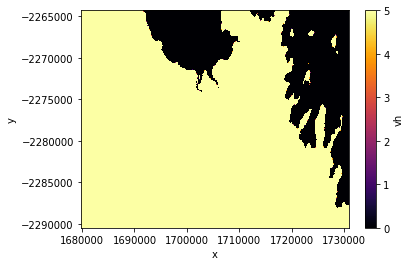

In [71]:
#time_slice = slice(None,'2016-11-12T19:36:30.178718000')
time_slice = slice('2017-02-28','2017-03-31')
z_subset = z.sel(time=time_slice)
print(z_subset.time.values)
(z_subset.vh!=z_subset.vh.nodata).sum(dim='time')[::4,::4].plot(cmap='inferno')

In [72]:
# Need to get the radar and cats data into a single list by 'flattening' the data using- 
flatcats = cats.stack(i = ('x','y'))
flatmz = mz.stack(i = ('x','y'))
flatradar = radar.stack(i = ('x','y'))
# Check that they are still looking good
print(flatcats)
print(flatmz) 
print(flatradar)

<xarray.DataArray (i: 2137974)>
array([ 949.,  949.,  949., ...,  774.,  774.,  774.])
Coordinates:
  * i        (i) MultiIndex
  - x        (i) float64 1.68e+06 1.68e+06 1.68e+06 1.68e+06 1.68e+06 ...
  - y        (i) float64 -2.264e+06 -2.264e+06 -2.264e+06 -2.264e+06 ...
Attributes:
    crs:      epsg:3577
<xarray.DataArray (i: 2137974)>
array([ 949.,  949.,  949., ...,  774.,  774.,  774.])
Coordinates:
  * i        (i) MultiIndex
  - x        (i) float64 1.68e+06 1.68e+06 1.68e+06 1.68e+06 1.68e+06 ...
  - y        (i) float64 -2.264e+06 -2.264e+06 -2.264e+06 -2.264e+06 ...
Attributes:
    crs:      epsg:3577
<xarray.DataArray 'vh' (i: 2137974)>
array([ 0.027586,  0.033448,  0.038186, ...,  0.055036,  0.042923,  0.035227])
Coordinates:
  * i        (i) MultiIndex
  - x        (i) float64 1.68e+06 1.68e+06 1.68e+06 1.68e+06 1.68e+06 ...
  - y        (i) float64 -2.264e+06 -2.264e+06 -2.264e+06 -2.264e+06 ...


In [73]:
good_subset = np.isfinite(radar) & np.isfinite(mz)
good_radar = radar.data[good_subset]
good_mz = mz.data[good_subset]
#good_both = np.vstack([good_radar, good_mz])
df = pd.DataFrame(data=dict(radar_column=good_radar, mz_column=good_mz))
mapping = {1063:'bare', 1000:'water', 949:'grassy', 898:'woodland', 806:'urban', 774:'forest'}
# sns.factorplot(data=df, y_order=['bare', 'water', 'grassy', 'woodland', 'urban', 'forest'])- sharon's attempt at category order
df['mz_label'] = df.mz_column.map(mapping)
df.head() # only show a few rows

,mz_column,radar_column,mz_label
0,949.0,0.027586,grassy
1,949.0,0.037789,grassy
2,949.0,0.033720,grassy
3,949.0,0.032542,grassy
4,949.0,0.032714,grassy


(0, 0.1)

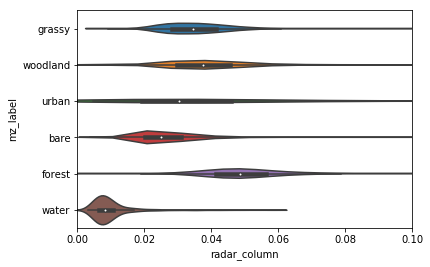

In [74]:
smaller = df.iloc[::10]
#len(smaller)
ax = sns.violinplot(data=smaller, x='radar_column', y='mz_label', scale="area")#, cut=0)#, bw=20)
ax.set_xlim([0,0.1])

In [75]:
good_subset = np.isfinite(radar) & np.isfinite(mz)
good_radar = radar.data[good_subset]
good_mz = mz.data[good_subset]
#good_both = np.vstack([good_radar, good_mz])
df = pd.DataFrame(data=dict(radar_column=good_radar, mz_column=good_mz))
mapping = {1063:'bare', 1000:'water', 949:'grassy', 898:'woodland', 806:'urban', 774:'forest'}
df['mz_label'] = df.mz_column.map(mapping)
df.head() # only show a few rows

,mz_column,radar_column,mz_label
0,949.0,0.027586,grassy
1,949.0,0.037789,grassy
2,949.0,0.033720,grassy
3,949.0,0.032542,grassy
4,949.0,0.032714,grassy


(0, 0.09)

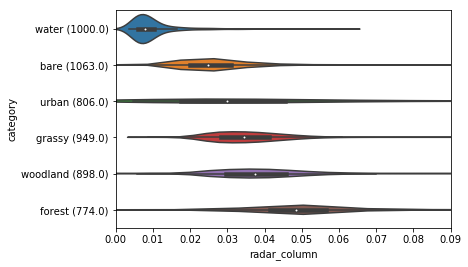

In [76]:
# Try to specify ordering of violin plot
df2 = df.copy()
df2['order'] = df2.mz_label.map(dict(water=1,bare=2,urban=3,grassy=4,woodland=5,forest=6))
df2.sort_values('order', inplace=True)
df2['category'] = df2.mz_label + ' (' + df2.mz_column.map(str) + ')'
ax = sns.violinplot(data=df2.iloc[::10], x='radar_column', y='category', scale="area")
ax.set_xlim([0,0.09])
#Claire's suggested scripting for ordering -
#order = ['water', 'bare', 'urban', 'grassy', 'woodland', 'forest']
#ax = sns.countplot(x="CONDITION", hue="HABITABLE", data=df, order=order)